<a href="https://colab.research.google.com/github/pxs1990/Data_Science_projects/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ARIMA and SARIMAX model to predict tesla price**

The ARIMA model with AR order p, differencing order d, and MA order q is specified as ARIMA(p,d,q). Let's break down what each component represents:

AR Order (p = 10):

The autoregressive (AR) order is the number of lagged observations included in the model. In this case, the model includes 10 lagged observations of the dependent variable.

Differencing Order (d = 1):

The differencing order represents the number of times the time series is differenced to achieve stationarity. In this case, the time series has undergone first-order differencing, indicating that the values are the differences between consecutive observations.

MA Order (q = 13):

The moving average (MA) order is the number of lagged forecast errors included in the model. In this case, the model includes 13 lagged forecast errors.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr#gets financia data from API like yahoo, nasdaq
from scipy import stats
import seaborn as sns

In [2]:
!pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38616 sha256=f78a6749fbe5a55a221027eb6e8a19f37202924431b63952c647c53d9201733e
  Stored in directory: /root/.cache/pip/wheels/cc/6b/dd/7ff776de4ebf7b144bb9562a813be59d0108306f368af9b637
Successfully built yahoofinancials


**Downloading Tesla Stock data for time series analysis**

In [3]:
# Date must be in the fromat ("%Y-%m-%d") That is, year-month-day
# Importing the yfinance package
from yahoofinancials import YahooFinancials
import yfinance as yf

# Set the start and end date
start_date = "2011-01-01"
end_date = "2024-01-31"

# Set the ticker
ticker = "TSLA"

# Get the data
tesla = yf.download(ticker, start_date, end_date)

# Print the last 5 rows
print(tesla.head())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2011-01-03  1.789333  1.800000  1.726667  1.774667   1.774667  19245000
2011-01-04  1.777333  1.796667  1.734667  1.778000   1.778000  17811000
2011-01-05  1.765333  1.793333  1.746000  1.788667   1.788667  21700500
2011-01-06  1.788667  1.866667  1.787333  1.858667   1.858667  30918000
2011-01-07  1.866667  1.905333  1.860000  1.882667   1.882667  33718500


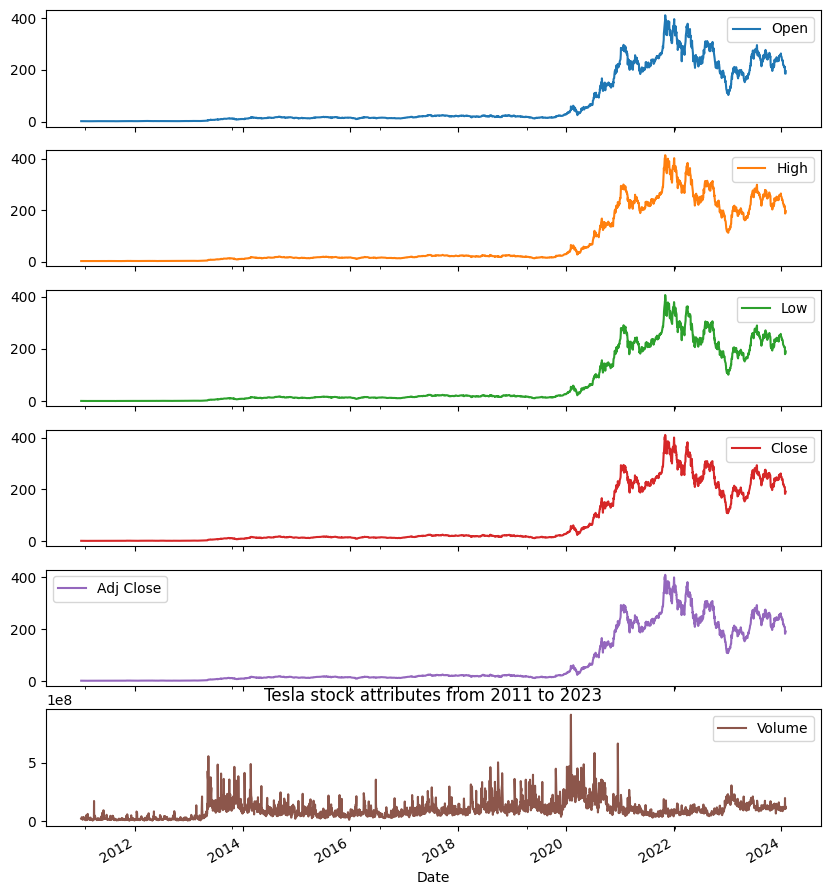

In [4]:
tesla.plot(subplots=True, figsize=(10,12))
plt.title('Tesla stock attributes from 2011 to 2023')
plt.show()


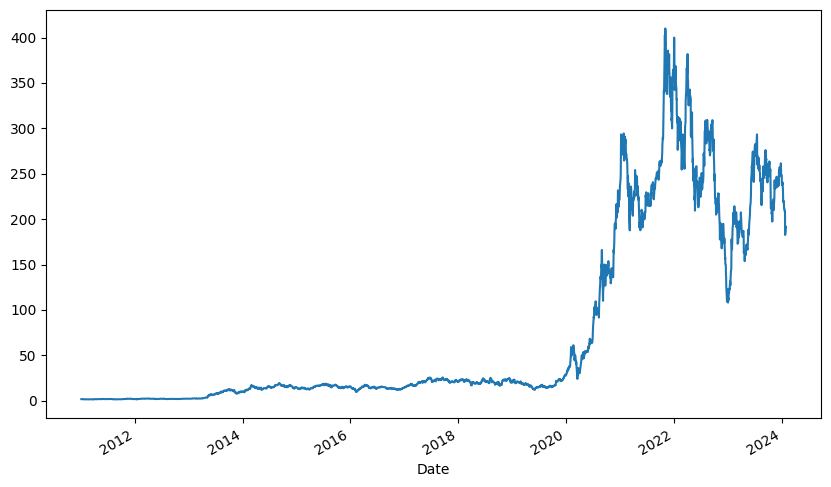

In [5]:
tesla['Adj Close'].plot(figsize=(10,6))
plt.show()

In [ ]:
# viewing monthly avg of adj close
y = tesla['Adj Close'].resample('MS').mean()
print(y)
y_df=pd.DataFrame(y)
y_df

Date
2011-01-01      1.709533
2011-02-01      1.555579
2011-03-01      1.580580
2011-04-01      1.744400
2011-05-01      1.840857
                 ...    
2023-09-01    256.968000
2023-10-01    236.907727
2023-11-01    229.411905
2023-12-01    247.137998
2024-01-01    217.572501
Freq: MS, Name: Adj Close, Length: 157, dtype: float64


,Adj Close
Date,
2011-01-01,1.709533
2011-02-01,1.555579
2011-03-01,1.580580
2011-04-01,1.744400
2011-05-01,1.840857
...,...
2023-09-01,256.968000
2023-10-01,236.907727
2023-11-01,229.411905


# **Decomposition of time series**

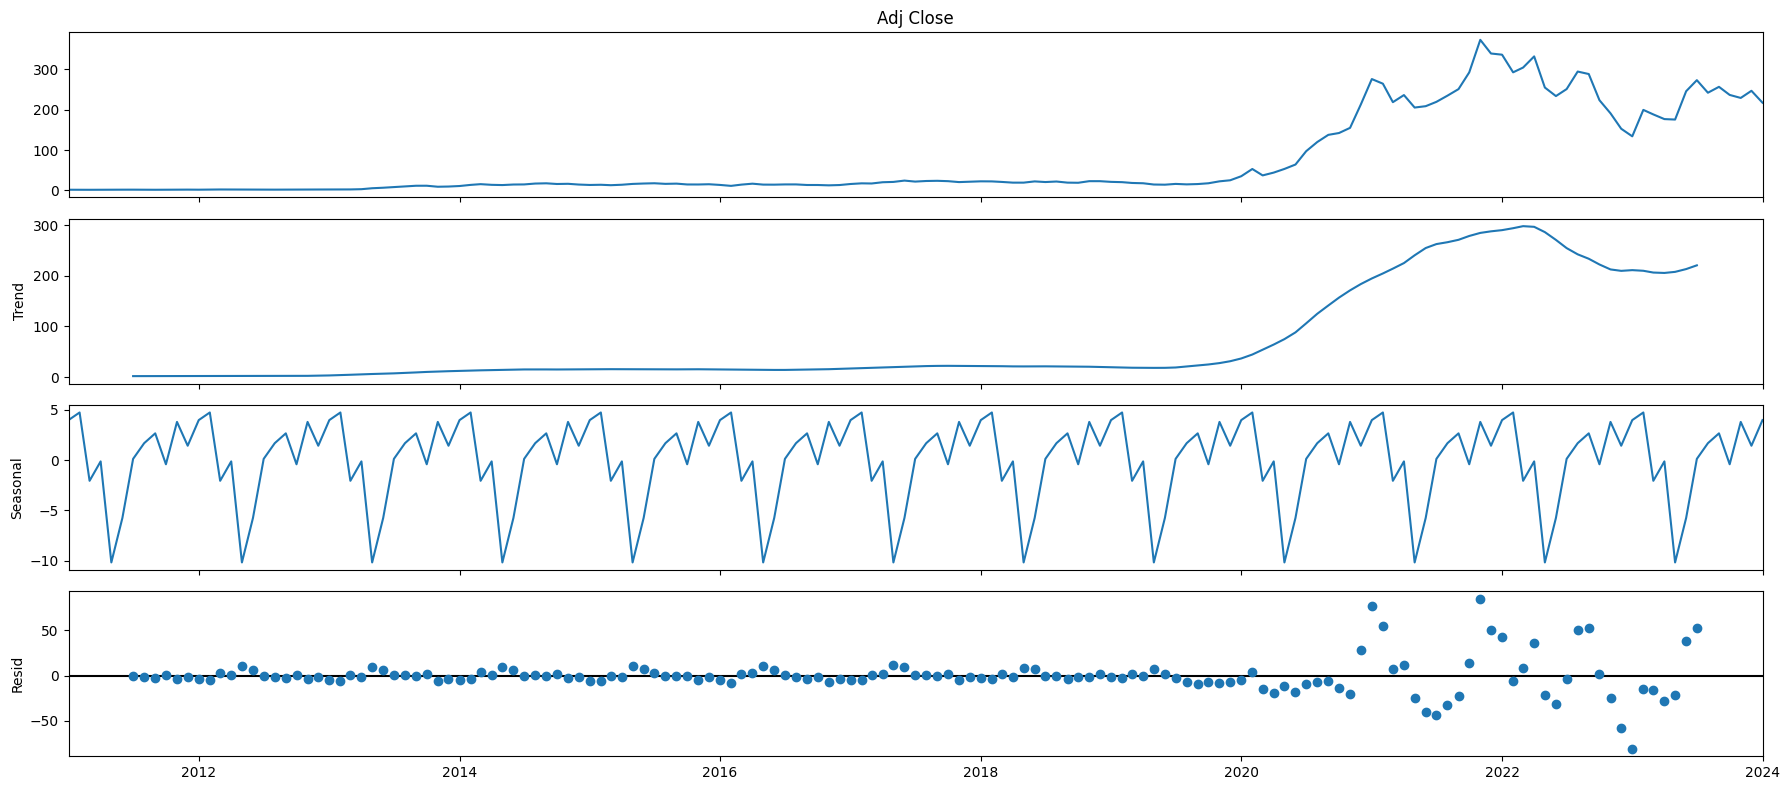

In [ ]:
import numpy as np
import statsmodels.api as sm
#------------------------
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')#or model=multipcative
fig = decomposition.plot()
plt.show()

In [ ]:
 y.isnull().sum()

0

# **Some Financial Analysis**

**Percent Change**

<Axes: xlabel='Date'>

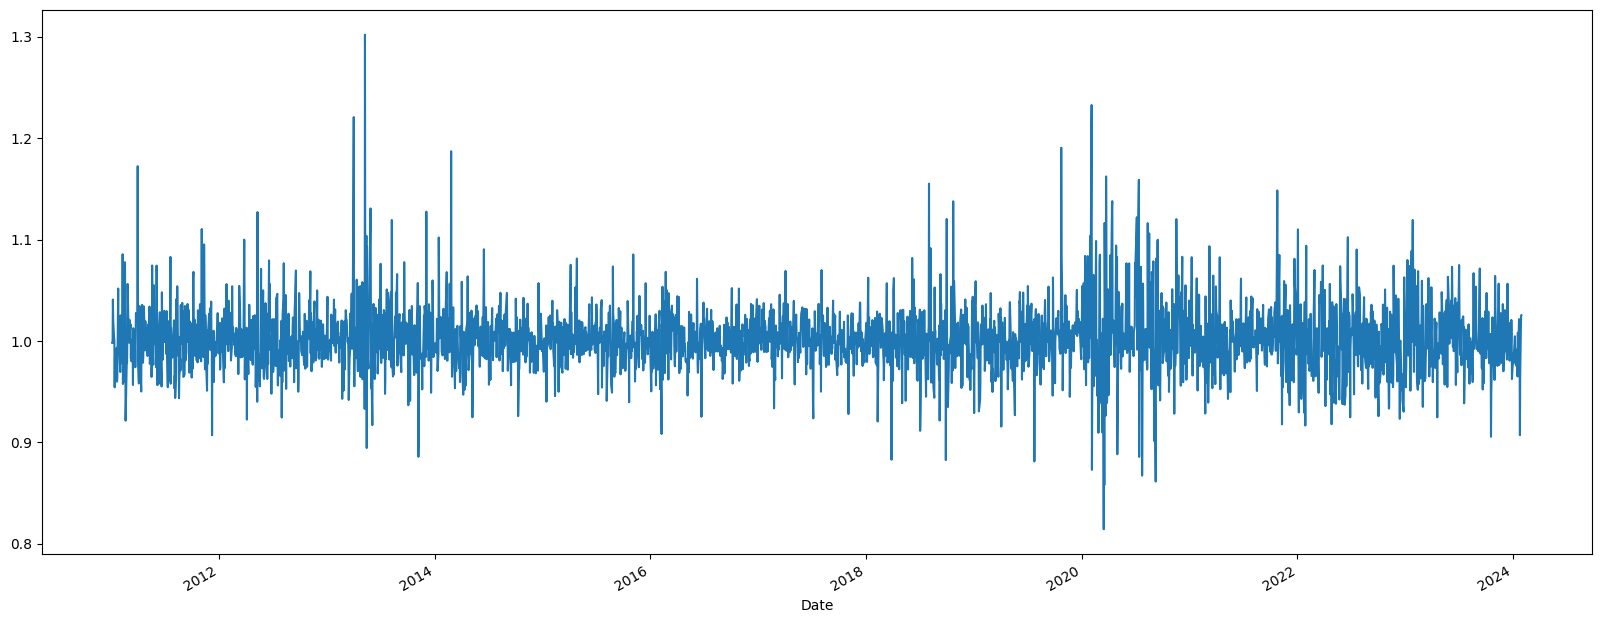

In [6]:
# daily change in the high prices of Tesla stock and create a new column called 'Change' in df
tesla['Change'] = tesla.High/(tesla.High.shift())
tesla['Change'].plot(figsize=(20,8))

**Stock Returns plot**

<Axes: xlabel='Date'>

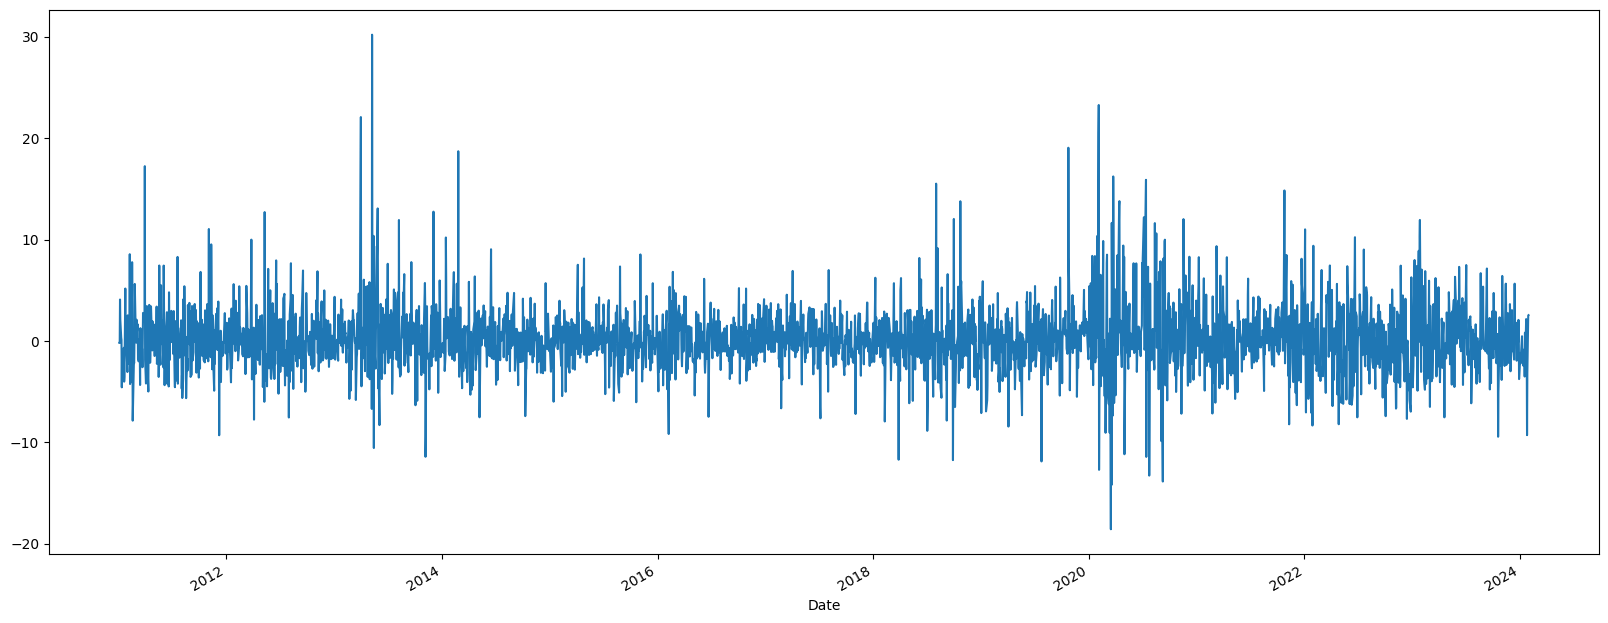

In [ ]:
#tesla['Return'] = tesla.Change.sub(1).mul(100)
tesla['Return'] = (tesla['Change'] - 1) * 100
tesla['Return'].plot(figsize=(20,8))

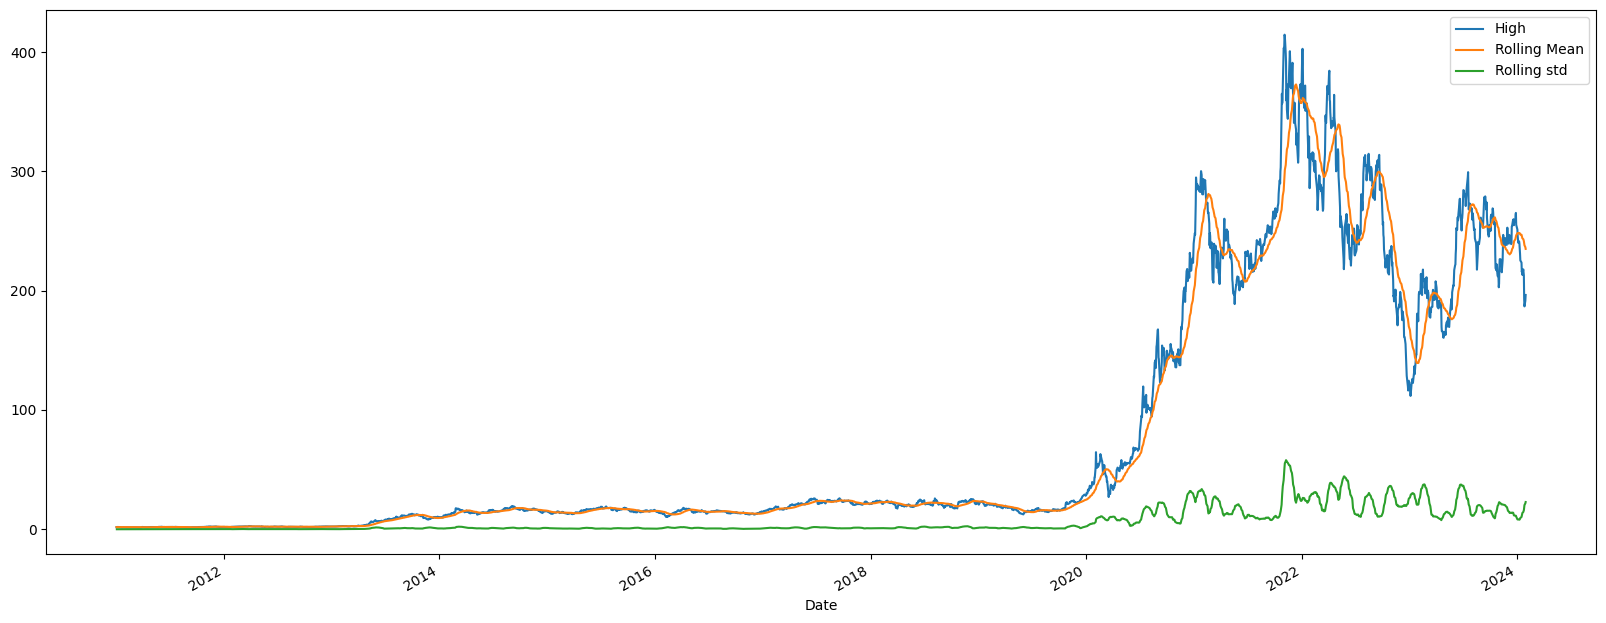

In [7]:
# Rolling window functions to find the rolling mean and std (for smoothness and checking non stationarity)
rolling_tesla_mean = tesla.High.rolling('50D').mean()
rolling_tesla_std = tesla.High.rolling('50D').std()
tesla.High.plot(figsize=(20,8))
rolling_tesla_mean.plot(figsize=(20,8))
rolling_tesla_std.plot(figsize=(20,8))
plt.legend(['High','Rolling Mean','Rolling std'])

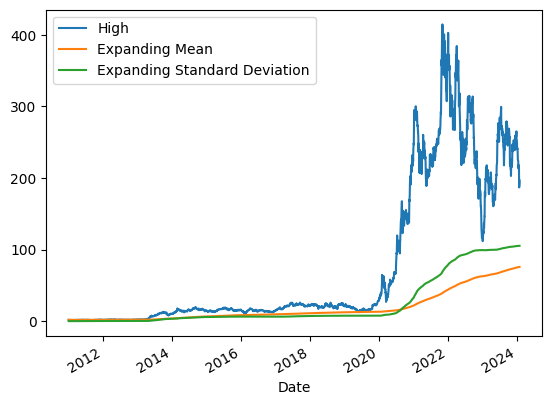

In [8]:
# Expanding window functions
tesla_mean = tesla.High.expanding().mean()#EM=cumulative mean=mean till today from the beginning
tesla_std = tesla.High.expanding().std()
tesla.High.plot()
tesla_mean.plot()
tesla_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

WE see that the expnding sd is higher that expanding mean which shows that stock is profitable. Since Rolling and expanding mean and sd are varying over the time, there is non stationarity.

# **OHLC**
The term "OHLC" stands for Open, High, Low, and Close, which are key data points used in financial markets and time series analysis. OHLC represents the four significant prices within a given time period for a financial instrument, such as a stock or currency. Here's a brief explanation of each component:

Open (O):

The opening price is the first traded price of a financial instrument at the beginning of a specific time period, such as a trading day or a candlestick interval.

High (H):

The high price represents the highest traded price of the financial instrument during the specified time period.

Low (L):

The low price is the lowest traded price of the financial instrument within the given time period.

Close (C):

The closing price is the last traded price of the financial instrument at the end of the specified time period.
OHLC data is commonly used to construct candlestick charts, which visually represent the price movements of a financial instrument over time. Each candlestick has a rectangular "body" representing the opening and closing prices, and vertical "wicks" or "shadows" extending from the body indicating the high and low prices.

In [10]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


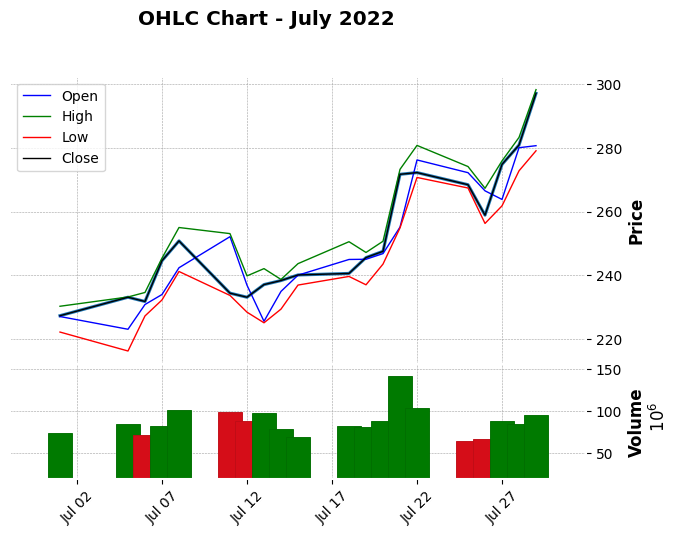

In [11]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Assuming 'tesla' is a DataFrame containing OHLC data for Tesla stock
# and the index of 'tesla' is a DateTimeIndex

# Filter the data for July 2022
start_date = '2022-07-01'
end_date = '2022-07-31'
tesla_july_2022 = tesla[start_date:end_date]

# Convert DataFrame to a format suitable for mplfinance
ohlc_data = tesla_july_2022[['Open', 'High', 'Low', 'Close', 'Volume']]
ohlc_data.index.name = 'Date'

# Create a custom legend with labels
custom_legend = [
    mpf.make_addplot(ohlc_data['Open'], panel=0, secondary_y=False, color='blue', label='Open',width=1),
    mpf.make_addplot(ohlc_data['High'], panel=0, secondary_y=False, color='green', label='High', width=1),
    mpf.make_addplot(ohlc_data['Low'], panel=0, secondary_y=False, color='red', label='Low',width=1),
    mpf.make_addplot(ohlc_data['Close'], panel=0, secondary_y=False, color='black', label='Close',width=1),
]

# Plot the OHLC lines with custom legend
mpf.plot(ohlc_data, type='line', style='charles', title='OHLC Chart - July 2022', ylabel='Price',
         ylabel_lower='Volume', volume=True, show_nontrading=True, addplot=custom_legend)

# Show the plot
plt.show()



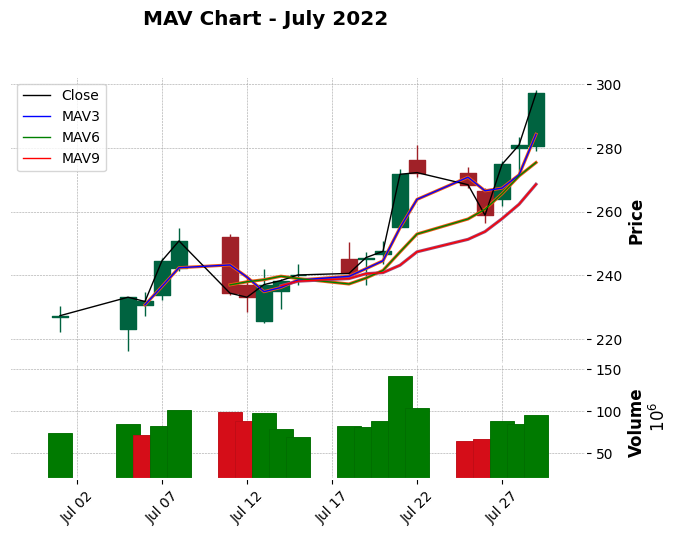

In [13]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Assuming 'tesla' is a DataFrame containing OHLC data for Tesla stock
# and the index of 'tesla' is a DateTimeIndex

# Filter the data for July 2022
start_date = '2022-07-01'
end_date = '2022-07-31'
tesla_july_2022 = tesla[start_date:end_date]

# Convert DataFrame to a format suitable for mplfinance
ohlc_data = tesla_july_2022[['Open', 'High', 'Low', 'Close', 'Volume']]
ohlc_data.index.name = 'Date'

# Calculate moving averages
for i in [3, 6, 9]:
    ohlc_data[f'MAV{i}'] = ohlc_data['Close'].rolling(window=i).mean()

# Create a custom legend with labels
custom_legend = [
    mpf.make_addplot(ohlc_data['Close'], panel=0, secondary_y=False, color='black', label='Close',width=1),
    mpf.make_addplot(ohlc_data['MAV3'], panel=0, secondary_y=False, color='blue', label='MAV3',width=1),
    mpf.make_addplot(ohlc_data['MAV6'], panel=0, secondary_y=False, color='green', label='MAV6',width=1),
    mpf.make_addplot(ohlc_data['MAV9'], panel=0, secondary_y=False, color='red', label='MAV9',width=1),
]

# Plot the OHLC chart with custom legend
mpf.plot(ohlc_data, type='candle', style='charles', mav=(3, 6, 9), title='MAV Chart - July 2022', ylabel='Price',
         ylabel_lower='Volume', volume=True, show_nontrading=True, addplot=custom_legend)

# Show the plot
plt.show()


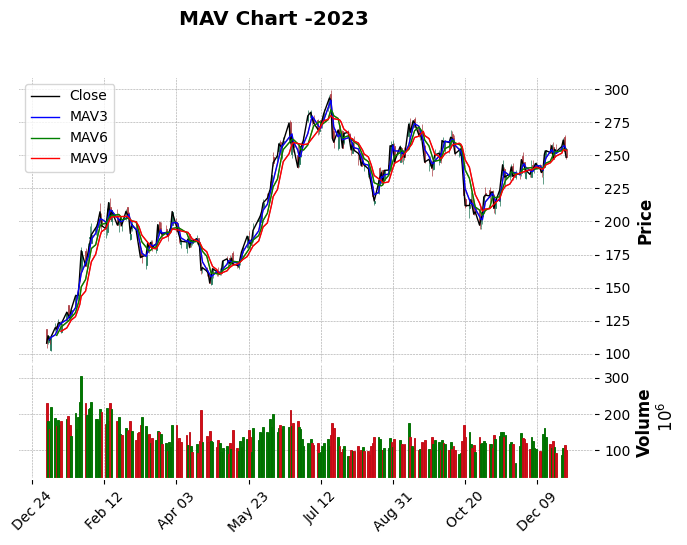

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Assuming 'tesla' is a DataFrame containing OHLC data for Tesla stock
# and the index of 'tesla' is a DateTimeIndex

# Filter the data for 2023
start_date = '2023-01-01'
end_date = '2023-12-31'
tesla_2023 = tesla[start_date:end_date]

# Convert DataFrame to a format suitable for mplfinance
ohlc_data = tesla_2023[['Open', 'High', 'Low', 'Close', 'Volume']]
ohlc_data.index.name = 'Date'

# Calculate moving averages
for i in [3, 6, 9]:
    ohlc_data[f'MAV{i}'] = ohlc_data['Close'].rolling(window=i).mean()

# Create a custom legend with labels
custom_legend = [
    mpf.make_addplot(ohlc_data['Close'], panel=0, secondary_y=False, color='black', label='Close',width=1),
    mpf.make_addplot(ohlc_data['MAV3'], panel=0, secondary_y=False, color='blue', label='MAV3',width=1),
    mpf.make_addplot(ohlc_data['MAV6'], panel=0, secondary_y=False, color='green', label='MAV6',width=1),
    mpf.make_addplot(ohlc_data['MAV9'], panel=0, secondary_y=False, color='red', label='MAV9',width=1),
]

# Plot the OHLC chart with custom legend
mpf.plot(ohlc_data, type='candle', style='charles', mav=(3, 6, 9), title='MAV Chart -2023', ylabel='Price',
         ylabel_lower='Volume', volume=True, show_nontrading=True, addplot=custom_legend)

# Show the plot
plt.show()

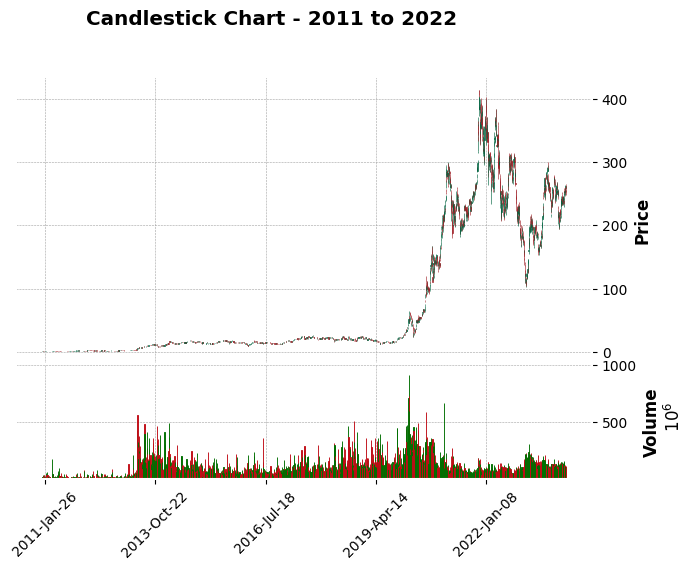

In [16]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

# Assuming 'tesla' is a DataFrame containing OHLC data for Tesla stock
# and the index of 'tesla' is a DateTimeIndex

# Filter the data for 2011 to 2023
start_date = '2011-01-01'
end_date = '2023-12-31'
tesla_2011_to_2023 = tesla[start_date:end_date]

# Convert DataFrame to a format suitable for mplfinance
ohlc_data = tesla_2011_to_2023[['Open', 'High', 'Low', 'Close', 'Volume']]
ohlc_data.index.name = 'Date'

# Plot the OHLC chart (only candlestick)
mpf.plot(ohlc_data, type='candle', style='charles', title='Candlestick Chart - 2011 to 2022', ylabel='Price',
         ylabel_lower='Volume', volume=True, show_nontrading=True)

# Show the plot
plt.show()

**Stationarity**:

 Stationarity implies that the statistical properties of a process generating a time series do not change over time. Some of the tools to check the the statioanrity are ACF, PACF.

# **Autocorrelation and Partial Autocorrelation (ACF & PACF)**
Autocorrelation (ACF) and Partial Autocorrelation (PACF) are statistical tools used in time series analysis to identify the presence of autocorrelation in a dataset.

**Autocorrelation Function (ACF):**

Autocorrelation measures the correlation between a time series and a lagged version of itself(lag=time difference betn observations in a time series).
The ACF at lag k, denoted as ACF(k), is calculated as the correlation between the time series values at time t and the values at time t - k.
The ACF helps to identify the overall pattern of dependence within the time series.The PACF helps in identifying the order of the Moving Average (MA).

**Partial Autocorrelation Function (PACF):**
The PACF helps in identifying the order of the AutoRegressive (AR) process by showing the direct relationship between each lag and the current observation, after removing the effects of the intervening lags.

PACF measures the correlation between a time series and a lagged version of itself while controlling for the effect of other lags.
The PACF at lag k, denoted as PACF(k), represents the correlation between the time series values at time t and the values at time t - k, with the linear dependence of the intermediate lags (t - 1, t - 2, ..., t - k + 1) removed.
The PACF helps to identify the direct relationship between the current and lagged values.
Both ACF and PACF are commonly used in the Box-Jenkins methodology for time series analysis, particularly in the identification phase of building ARIMA (AutoRegressive Integrated Moving Average) models.

ACF:

If ACF shows a sharp drop-off after a certain lag, it suggests that there is no autocorrelation beyond that lag.
If ACF shows a slow decay, it indicates a long memory in the time series.
PACF:

If PACF has a sharp drop-off after a certain lag, it suggests that the lag is a potentially good candidate for the order of the autoregressive (AR) component in an ARIMA model.
Significant spikes in PACF at certain lags may indicate the order of the autoregressive component.

**Plottig ACF**

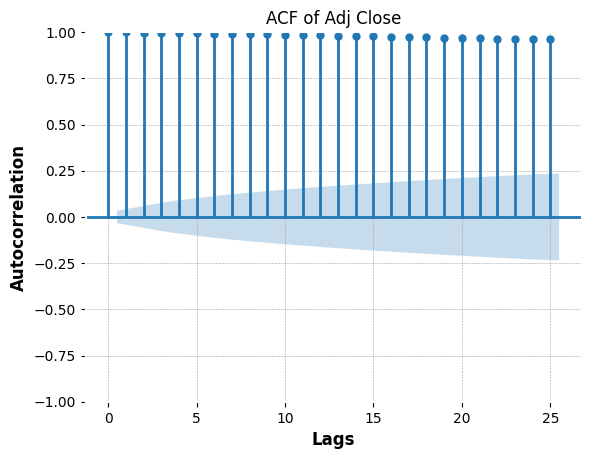

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(tesla["Adj Close"], lags=25, title="ACF of Adj Close")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

There is positive significant correlation above 0.25 at all lags so there's a good chance that the time series has a stochastic trend and seasonality, and will need a significant level of differencing( taking the difference between consecutive observations) to achieve stationarity.
Since there is no clear-cut result about the lags of the MA model because of continuously persistant autocorrelation, we are going to choose the auto-lag-selection ARIMA model


**Plotting PACF**

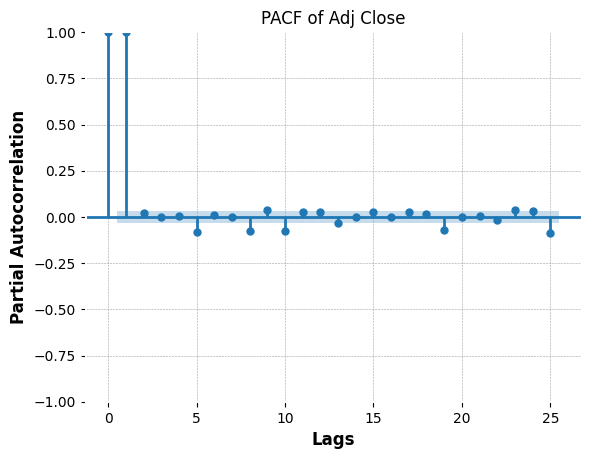

In [18]:
plot_pacf(tesla["Adj Close"], lags=25, title="PACF of Adj Close")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.show()

There is significant correlation in the first lag and  and in the subsiquent lags, correlations are with in the CI. This might be indicative of a simple autoregressive structure, possibly an AR(1) process, where each observation is primarily influenced by the one just before it.




Since there is no clear-cut result about the lags of the MA model because of continuously persistant autocorrelation(significant), we are going to choose the auto-lag-selection ARIMA model.

**Autoregressive (AR) Model:**
An Autoregressive (AR) model is a type of time series model where the current value of a variable is predicted as a linear combination of its past values. The "autoregressive" part indicates that the model uses its own past values for prediction.
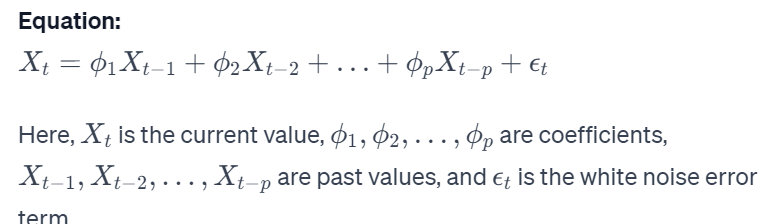

Purpose:
MA models help capture short-term fluctuations in time series data by modeling the influence of past error terms. They are suitable when there is a correlation between the current value and past errors.


# **Splitting the Data into Test and Train**

In [40]:
#splitting the data to train and test sets based on Ntest value
#last 500 days
Ntest = 500
train = tesla.iloc[:-Ntest]
test = tesla.iloc[-Ntest:]
train_idx = tesla.index <= train.index[-1]
test_idx = tesla.index > train.index[-1]

# **Building the ARIMA Model**

In [19]:
!pip install pmdarima
import pandas as pd
from pmdarima.arima import auto_arima
import pmdarima as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00


In [39]:
from pmdarima.arima.utils import ndiffs

# Calculate the number of differences needed for stationarity
d_val = ndiffs(tesla['Adj Close'], test='adf')
print('Arima D-value:', d_val)
#In this case, 'adf' stands for the Augmented Dickey-Fuller (ADF) test.

Arima D-value: 1


In [41]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [42]:
#Define auto-arima to find best model
model_arima = pm.auto_arima(train['Adj Close'],
                      d =d_val ,
                      start_p = 0,
                      max_p = 5,
                      start_q = 0,
                      max_q = 5,
                      stepwise=False,
                      max_order=5,
                      trace=True)


results_arima = model_arima.fit(train['Adj Close'])


# Calculate RMSE, MAE, and AIC for ARIMA
test_pred_arima = results_arima.predict(n_periods=len(test))
rmse_arima = np.sqrt(mean_squared_error(test['Adj Close'], test_pred_arima))
mae_arima = mean_absolute_error(test['Adj Close'], test_pred_arima)
aic_arima = results_arima.aic()

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=15115.199, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=15113.568, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=15115.054, Time=0.84 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=15109.624, Time=1.57 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=15111.260, Time=1.62 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=15107.839, Time=2.02 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=15113.682, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=15115.435, Time=1.36 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=15104.619, Time=1.80 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=15103.491, Time=2.30 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=15105.362, Time=4.31 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=15114.745, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=15103.753, Time=2.43 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=6.31 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=15104.019, Time=5.65 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [43]:
results_arima.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 1),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

# **Predicting from the ARIMA model**

In [44]:
# Make predictions for the next 12 periods
forecast, conf_int = results_arima.predict(n_periods=12, return_conf_int=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [45]:
print("Forecasted Values:")
print(forecast)

Forecasted Values:
2790    311.943849
2791    311.918030
2792    312.019058
2793    312.189525
2794    312.247599
2795    312.399809
2796    312.481132
2797    312.613511
2798    312.709671
2799    312.831361
2800    312.935100
2801    313.051448
dtype: float64


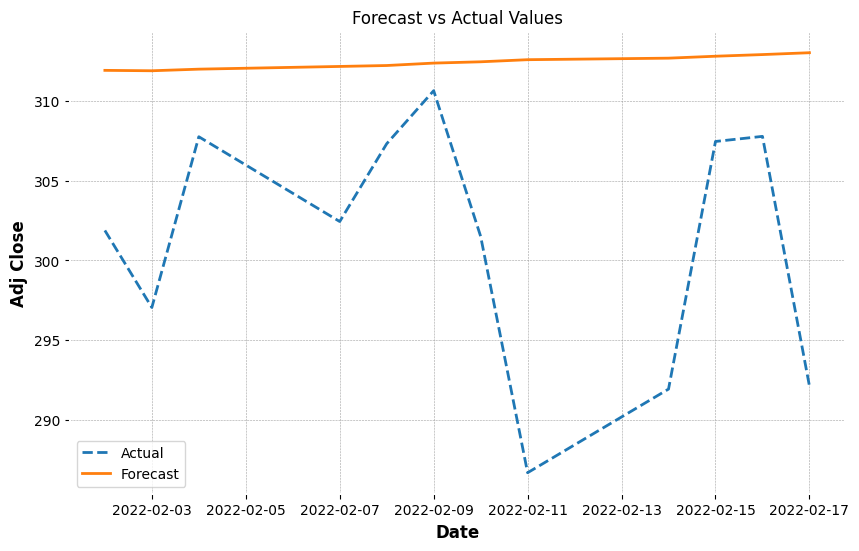

,Actual,Forecast
Date,,
2022-02-02,301.886658,311.943849
2022-02-03,297.046661,311.918030
2022-02-04,307.773346,312.019058
2022-02-07,302.446655,312.189525
2022-02-08,307.333344,312.247599
2022-02-09,310.666656,312.399809
2022-02-10,301.516663,312.481132
2022-02-11,286.666656,312.613511
2022-02-14,291.920013,312.709671


In [46]:
# Convert the index of the forecast to datetime for plotting
forecast_index = pd.date_range(start=test.index[0], periods=len(forecast), freq='B')

# Create a DataFrame with forecast and actual values
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecast': forecast})
forecast_df.set_index('Date', inplace=True)

# Extract actual values from the test set with the same index as forecast_df
actual_values = test.loc[forecast_df.index, 'Adj Close']

# Plot forecast and actual values
plt.figure(figsize=(10, 6))
plt.plot(actual_values.index, actual_values, label='Actual', linestyle='dashed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast')
plt.title('Forecast vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

# Display the forecast and actual values
model_df = pd.concat([ pd.DataFrame({'Actual': actual_values}),forecast_df], axis=1)
model_df

In [47]:
print(conf_int)# 2d array of up and lower bound

[[304.8480091  319.03968795]
 [302.0369004  321.79915948]
 [300.05468076 323.98343514]
 [298.28276335 326.09628717]
 [296.76582046 327.72937738]
 [295.40047532 329.39914366]
 [294.14829164 330.81397249]
 [292.99848588 332.22853688]
 [291.91744572 333.50189685]
 [290.90766546 334.75505645]
 [289.94721969 335.92298104]
 [289.03865963 337.06423605]]


# **Fitted vs Actual vs predicted data plot**

In [48]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [52]:
def plot_result(model, data, col_name, Ntest):

    params = model.get_params()
    d = params['order'][1]

    #In sample data prediction
    train_pred = model.predict_in_sample(start=d, end=-1)
    #out of sample prediction
    test_pred, conf = model.predict(n_periods=Ntest, return_conf_int=True)

    #plotting real values, fitted values and prediction values
    fig, ax= plt.subplots(figsize=(15,8))
    ax.plot(data[col_name].index, data[col_name], label='Actual Values')
    ax.plot(train.index[d:], train_pred, color='green', label='Fitted Values')
    ax.plot(test.index, test_pred, label='Forecast Values')
    ax.fill_between(test.index, conf[:,0], conf[:,1], color='red', alpha=0.3)
    ax.legend()

    #evaluating the model using RMSE and MAE metrics
    y_true = test[col_name].values
    rmse_arima = np.sqrt(mean_squared_error(y_true,test_pred))
    mae_arima = mean_absolute_error(y_true,test_pred)

    return rmse_arima, mae_arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Root Mean Squared Error:  119.69709761688591
Mean Absolute Error:  106.82049353712392


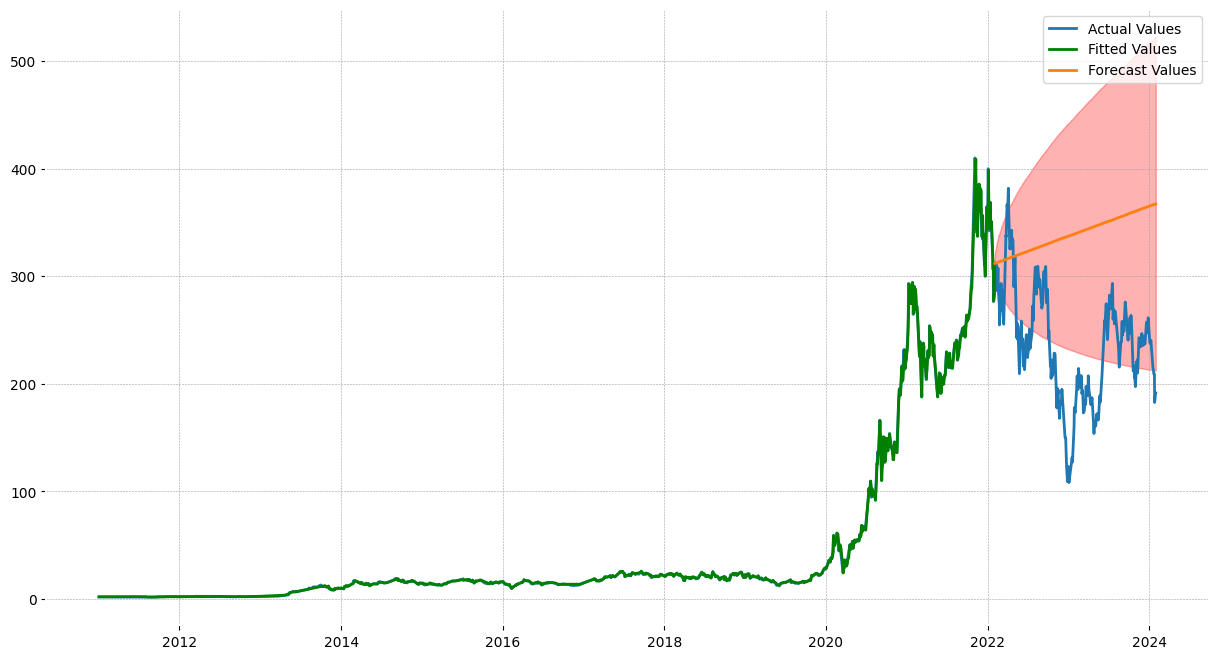

In [49]:
rmse_arima , mae_arima = plot_result(results_arima, tesla, 'Adj Close', Ntest=500)
print('Root Mean Squared Error: ', rmse_arima)
print('Mean Absolute Error: ', mae_arima)

# **Diagonistic Test: detects any patterns or deficiencies in the model residuals**

Top-left Plot (Standardized Residuals over Time):

This plot shows the standardized residuals over time. Residuals are the differences between the actual values and the values predicted by the model. Standardized residuals are normalized versions of these differences.
Ideally, you want the residuals to be randomly scattered around zero, indicating that the model captures the underlying patterns in the data.

Top-right Plot (Kernel Density Estimate of Residuals):

This is a kernel density estimate (KDE) of the distribution of the standardized residuals. It provides an overview of the shape of the distribution.
A normal distribution is desirable, suggesting that the residuals follow a Gaussian (bell-shaped) distribution. Any deviations from normality may indicate issues with the model.

Bottom-left Plot (QQ Plot):

The QQ (Quantile-Quantile) plot compares the quantiles of the standardized residuals with the quantiles of a theoretical normal distribution.
Ideally, the points should fall along a straight line. Deviations from the line suggest departures from normality.

Bottom-right Plot (Correlogram or Autocorrelation Function):

This plot displays the autocorrelation function (ACF) of the standardized residuals.
The blue shaded region represents the 95% confidence interval. Residuals outside this interval may indicate significant autocorrelation.

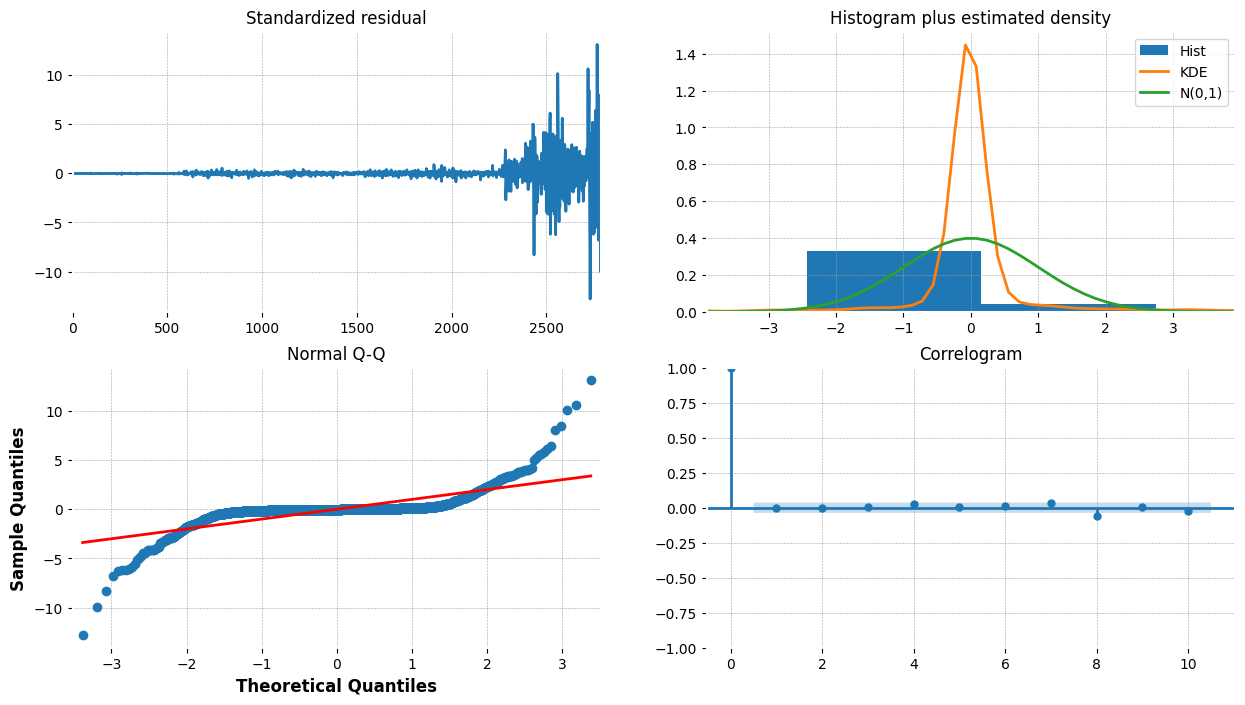

In [53]:
results_arima.plot_diagnostics(figsize=(15,8))
plt.show()


In [ ]:
#hist is left skewed. Data is not perfectly normal. Lets add Seasonality.

# **Seasonality**

In [54]:
#resampling daily data to monthly
y = tesla['Adj Close'].resample('MS').mean()
y

Date
2011-01-01      1.709533
2011-02-01      1.555579
2011-03-01      1.580580
2011-04-01      1.744400
2011-05-01      1.840857
                 ...    
2023-09-01    256.968000
2023-10-01    236.907727
2023-11-01    229.411905
2023-12-01    247.137998
2024-01-01    217.572501
Freq: MS, Name: Adj Close, Length: 157, dtype: float64

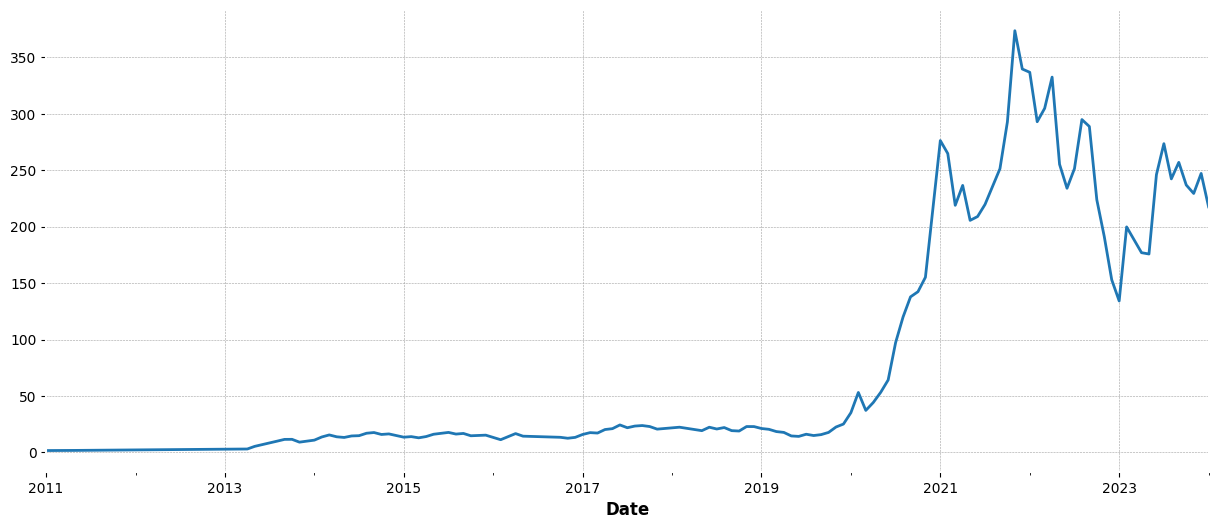

In [55]:
#plotting the monthly data
y.plot(figsize=(15, 6))
plt.show()

# **Decomposing times series into its components:**

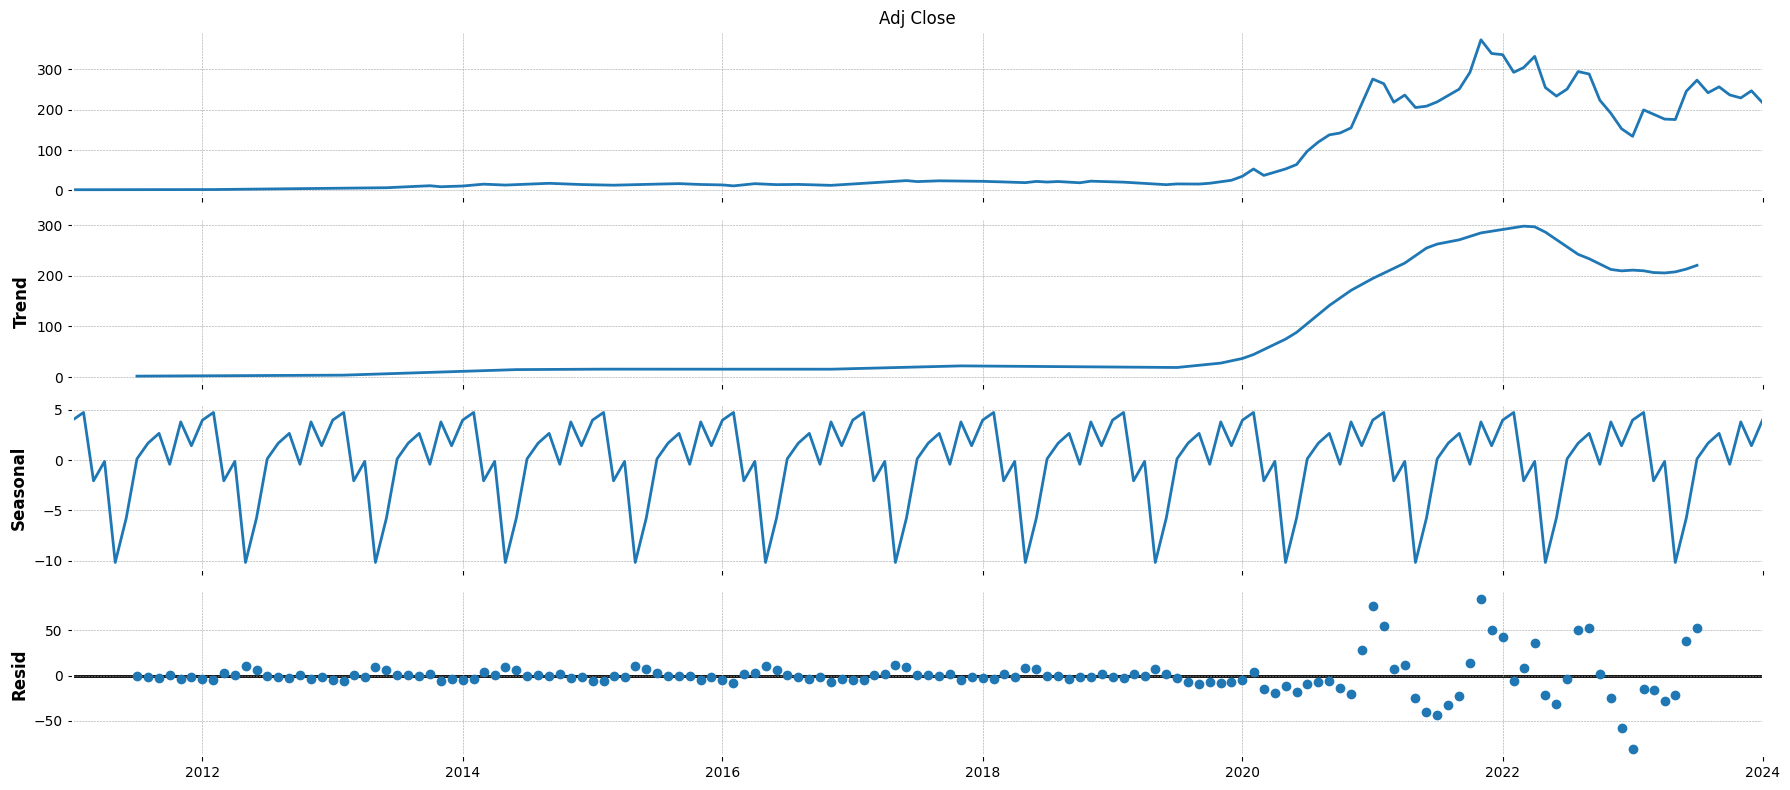

In [56]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# **Parameter Selection for SARIMA model**

In [57]:
import itertools
# Define parameters for SARIMAX model
p = q = range(0, 2)
d = [1]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Initialize lists to store actual and predicted values for SARIMAX
actual_values_sarimax = []
predicted_values_sarimax = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod_sarimax = sm.tsa.statespace.SARIMAX(train['Adj Close'],
                                                     order=param,
                                                     seasonal_order=param_seasonal,
                                                     enforce_stationarity=False,
                                                     enforce_invertibility=False)
            results_sarimax = mod_sarimax.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_sarimax.aic))

            # Make predictions for SARIMAX
            pred_sarimax = results_sarimax.get_prediction(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
            pred_ci_sarimax = pred_sarimax.conf_int()

            # Store actual and predicted values for SARIMAX
            actual_values_sarimax.extend(test['Adj Close'].values)
            predicted_values_sarimax.extend(pred_sarimax.predicted_mean.values)

        except Exception as e:
            print("Error:", e)
            continue


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p

ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:16574.55772865322
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:15022.480372859905


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:15458.539764760664


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:15020.087439953324


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:16571.146148406777


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:15018.596807581376


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:15460.505492882035


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:15015.187712233292
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:16576.078131220554


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:15023.369799803666


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:15455.91548721987


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:15020.312695385019


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:16569.325613595138


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:15020.486261402591


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:15454.240126300705


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:15017.134727804201


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [70]:
forecast_results = results_sarimax.get_forecast(steps=12)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [71]:
import pandas as pd

# Assuming 'test' DataFrame is already defined with Date index
date_index_first_12 = test.index[:12]

# Truncate the actual and predicted values to the first 12 values
actual_values_first_12 = actual_values_sarimax[:12]
predicted_values_first_12 = predicted_values_sarimax[:12]

# Create a DataFrame for first 12 actual and predicted values with Date index
sarimax_first_12_df = pd.DataFrame({'Actual': actual_values_first_12,
                                     'Predicted': predicted_values_first_12},
                                    index=date_index_first_12)

# Display the DataFrame
print(sarimax_first_12_df)


                Actual   Predicted
Date                              
2022-02-02  301.886658  316.433319
2022-02-03  297.046661  310.066650
2022-02-04  307.773346  298.446655
2022-02-07  302.446655  298.653320
2022-02-08  307.333344  281.196655
2022-02-09  310.666656  276.563324
2022-02-10  301.516663  272.696655
2022-02-11  286.666656  279.033325
2022-02-14  291.920013  242.929993
2022-02-15  307.476654  248.679993
2022-02-16  307.796661  278.803314
2022-02-17  292.116669  276.979980


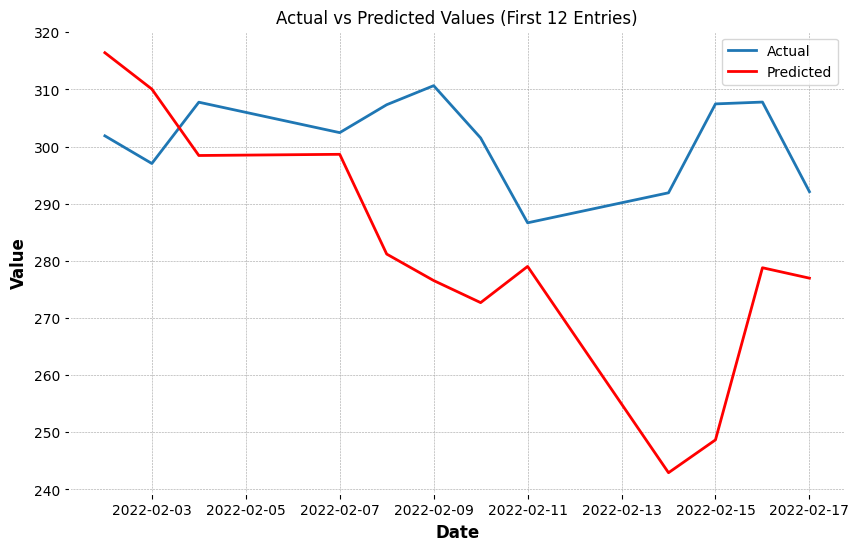

In [72]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for the first 12 entries
plt.figure(figsize=(10, 6))
plt.plot(sarimax_first_12_df.index, sarimax_first_12_df['Actual'], label='Actual')
plt.plot(sarimax_first_12_df.index, sarimax_first_12_df['Predicted'], color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (First 12 Entries)')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
# Calculate RMSE, MAE, and AIC for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(actual_values_sarimax, predicted_values_sarimax))
mae_sarimax = mean_absolute_error(actual_values_sarimax, predicted_values_sarimax)
aic_sarimax = results_sarimax.aic

# **Deagonistic Test**

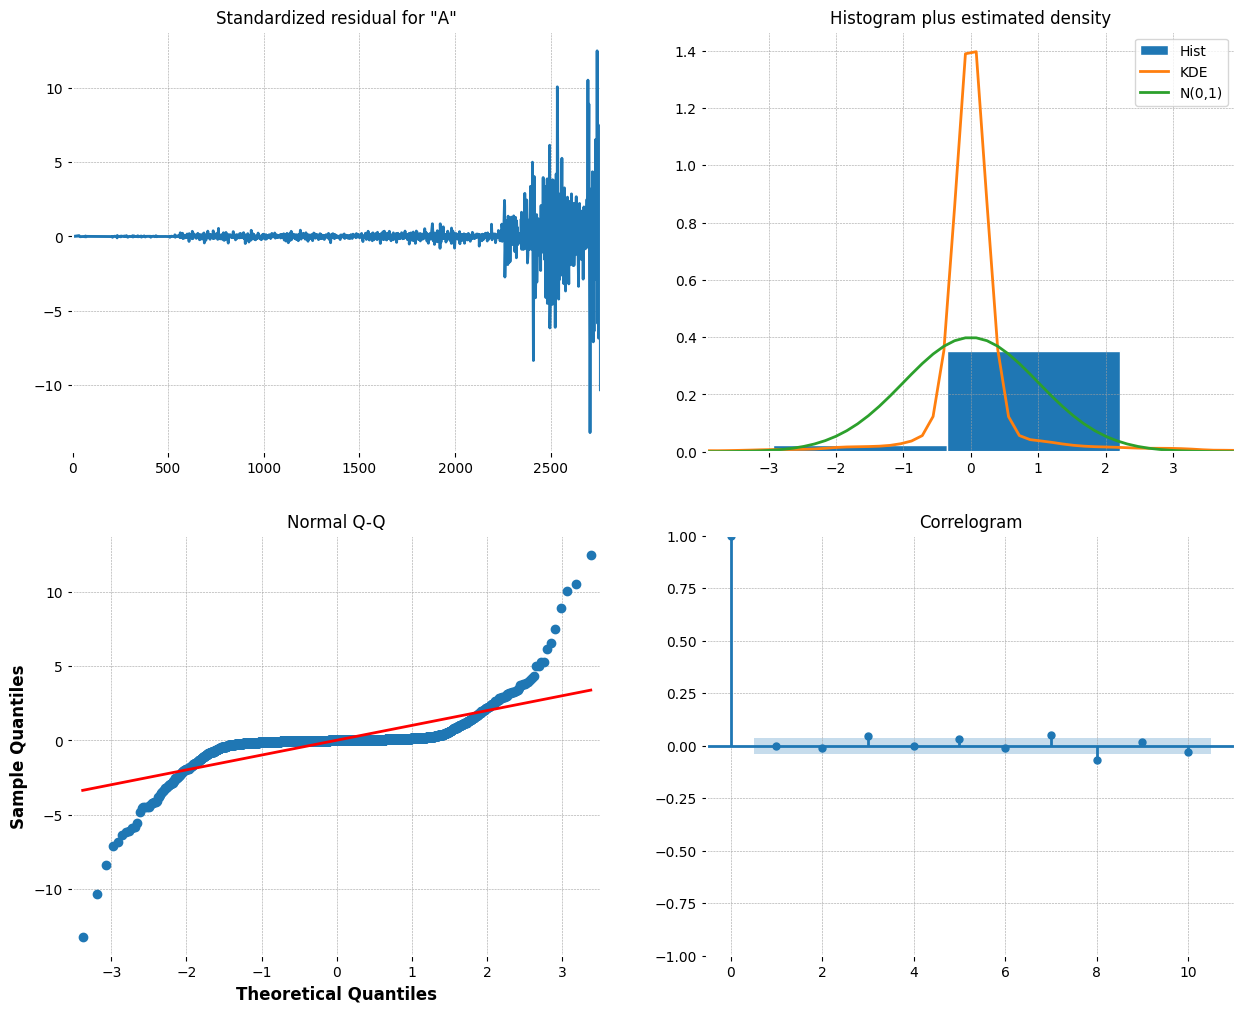

In [75]:
results_sarimax.plot_diagnostics(figsize=(15, 12))
plt.show()

# **Comparing the performance of ARIMA and SARIMAX model**

In [76]:
from tabulate import tabulate
# Print RMSE, MAE, and AIC for both models in a table
results_table = [
    ["ARIMA", rmse_arima, mae_arima, aic_arima],
    ["SARIMAX", rmse_sarimax, mae_sarimax, aic_sarimax]
]

print(tabulate(results_table, headers=["Model", "RMSE", "MAE", "AIC"], tablefmt="grid"))



+---------+---------+---------+---------+
| Model   |    RMSE |     MAE |     AIC |
+=========+=========+=========+=========+
| ARIMA   | 119.697 | 106.82  | 15103.4 |
+---------+---------+---------+---------+
| SARIMAX | 487.468 | 358.068 | 15017.1 |
+---------+---------+---------+---------+


while the ARIMA model outperforms the SARIMAX model in terms of RMSE and MAE, the SARIMAX model shows a better balance between model fit and complexity based on the AIC value. Therefore, the choice between the two models may depend on the specific objectives and requirements of the analysis